In [1]:
from utils import *

## Code to create dataset for Transfer Learning from the first 5 to the second 5 classes of MNIST

In [2]:
import torch
from torchvision import datasets, transforms

class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)
        
        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)

        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len])
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len])

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False)
        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False)

        # Separate test loaders
        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False)
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False)


In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F

class TransferLearningMNISTWrapper:
    def __init__(self, transferLearningMNISTObj, phase):
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)
        
    def update_phase(self, phase):
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

## Custom fuctions. Note: integrate into util.py

In [4]:
def compute_training_acc_epochs(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])   
    # if debug: print(model, optimizer)

    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

            if params['early_stop_patience']:
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1
                    print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                    if no_improve_epochs >= params['early_stop_patience']:
                        print("Early stopping invoked.")
                        break
        
        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
        checkpoints.append(checkpoint)

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model, checkpoints

In [5]:
def generate_fc_dnn(input_dim, output_dim, params):
    depth, width = params['depth'], params['width']
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))

    fc_list = list()
    for i in range(depth):
        fc_list += [
            nn.Linear(*gen_linear_layer_dim(i)),
            nn.LogSoftmax(dim=1) if (depth - 1 == i) else nn.Tanh()
        ]
    model = nn.Sequential(*fc_list)
    #model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model

In [30]:
def generate_fc_dnn(input_dim, output_dim, params):
    depth, width = params['depth'], params['width']
    
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))
    
    model = nn.Sequential()
    
    for i in range(depth):
        linear_layer = nn.Linear(*gen_linear_layer_dim(i))
        activation_layer = nn.LogSoftmax(dim=1) if (depth - 1 == i) else nn.Tanh()
        
        # Give descriptive names to layers
        setattr(model, f"linear{i}", linear_layer)
        setattr(model, f"activation{i}", activation_layer)
        
    return model


In [20]:
def compute_layer_variances_dense(model, test_loader, device='cpu'):
    # Define a hook to collect activations
    activations = {}

    def create_hook(name):
        def hook(module, input, output):
            activations[name] = output
        return hook


    for name, layer in model.named_modules():
        if name:  # this ensures we skip the top-level module (the entire model) which has an empty name
            layer.register_forward_hook(create_hook(name))

    # Run inference on the test set
    with torch.no_grad():
        for data, target in test_loader:
            #images = images.to(device)
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            outputs = model(data)

    # Calculate variance for each layer's activations
    variances = {key: torch.var(act, dim=0) for key, act in activations.items()}
    
    result = {}
    for layer_name, variance in variances.items():
        result[layer_name] = {
            'variance': variance.mean().item(),
            'variance_of_variance': torch.var(variance).item()
        }

    return result, variances

# Transfer Learning from the first 5 to the second 5 of MNIST. Default initialization with freezing.

In [43]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
depth = 5

dataset = TransferLearningMNIST(batch_size)
dataset_wrapped = TransferLearningMNISTWrapper(dataset, 'pretrain')
params = dict(device=device,
                width=50, lr=0.01, num_train=4,
                sb=1, depth= depth, sw=1.5, early_stop_patience = 2)

model = generate_fc_dnn(dataset.input_dim, dataset.output_dim,
                params).to(device)


Layer linear0 - Variance: 0.024446267634630203, Variance of Variance: 0.00011400150833651423
Layer activation0 - Variance: 0.02107565477490425, Variance of Variance: 8.358582999790087e-05
Layer linear1 - Variance: 0.007129864301532507, Variance of Variance: 9.711732673167717e-06
Layer activation1 - Variance: 0.00665966235101223, Variance of Variance: 6.810097147535998e-06
Layer linear2 - Variance: 0.0025601075030863285, Variance of Variance: 2.016415919570136e-06
Layer activation2 - Variance: 0.0024891397915780544, Variance of Variance: 1.8637368839335977e-06
Layer linear3 - Variance: 0.0006905522895976901, Variance of Variance: 9.634998576757425e-08
Layer activation3 - Variance: 0.0006739860982634127, Variance of Variance: 9.260480737793841e-08
Layer linear4 - Variance: 0.0002692861307878047, Variance of Variance: 1.8632128728768294e-08
Layer activation4 - Variance: 0.0002463211421854794, Variance of Variance: 1.1168672209294073e-08


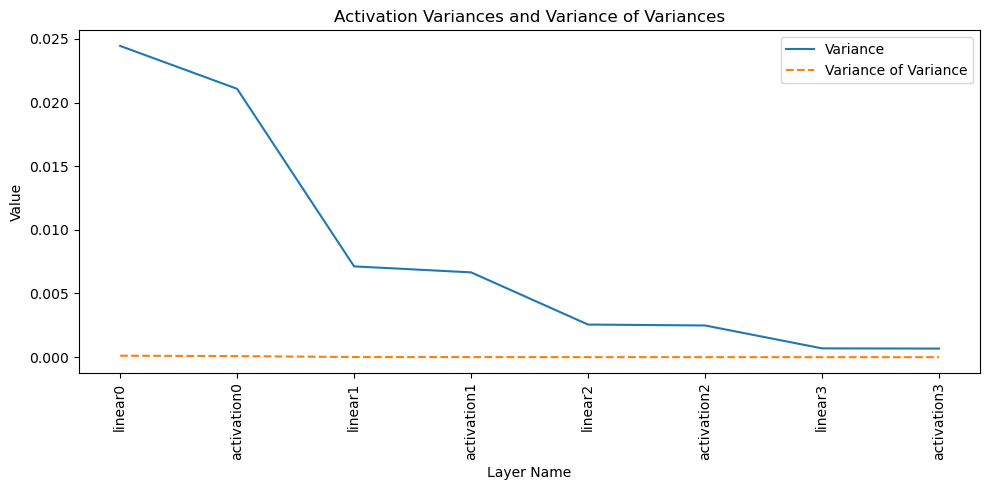

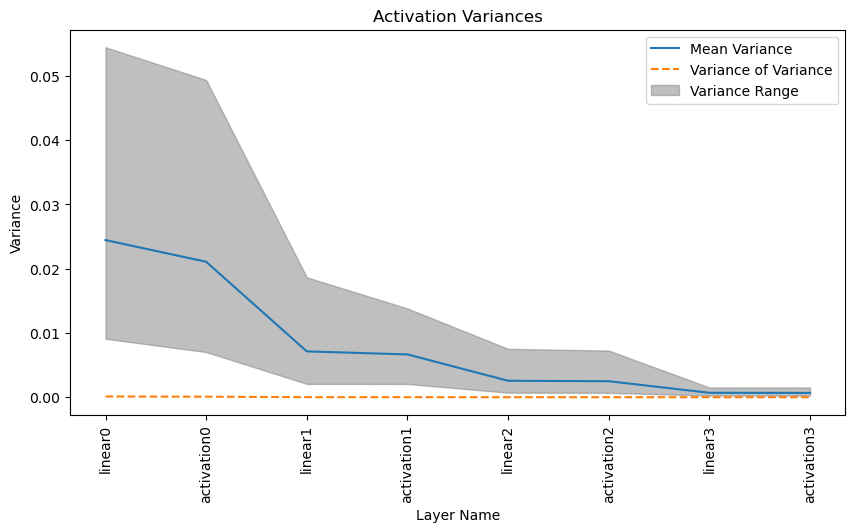

In [44]:
results, variances = compute_layer_variances_dense(model, dataset_wrapped.train_loader, device = 'cpu')
for layer_name, stats in results.items():
    print(f"Layer {layer_name} - Variance: {stats['variance']}, Variance of Variance: {stats['variance_of_variance']}")


import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]
variance_of_variance_values = [results[layer]['variance_of_variance'] for layer in layer_names]

# Plot the variances
plt.figure(figsize=(10, 5))
plt.plot(layer_names[:-2], variance_values[:-2], label='Variance')
plt.plot(layer_names[:-2], variance_of_variance_values[:-2], label='Variance of Variance', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Value')
plt.title('Activation Variances and Variance of Variances')
plt.legend()
plt.tight_layout()
plt.show()

# Create lists for mean, min, and max variance for each layer
layer_names = list(variances.keys())
mean_variances = [variance.mean().item() for variance in variances.values()]
min_variances = [variance.min().item() for variance in variances.values()]
max_variances = [variance.max().item() for variance in variances.values()]

# Plot the variances
plt.figure(figsize=(10, 5))
plt.plot(layer_names[:-2], mean_variances[:-2], label='Mean Variance')
plt.plot(layer_names[:-2], variance_of_variance_values[:-2], label='Variance of Variance', linestyle='--')

# Shade the region between the min and max variance
plt.fill_between(layer_names[:-2], min_variances[:-2], max_variances[:-2], color='gray', alpha=0.5, label='Variance Range')

plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.legend()
plt.show()

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/446557883.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(conv_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/446557883.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(activation_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/446557883.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(conv_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/446557883.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(activation_layer_names, rotation=90)


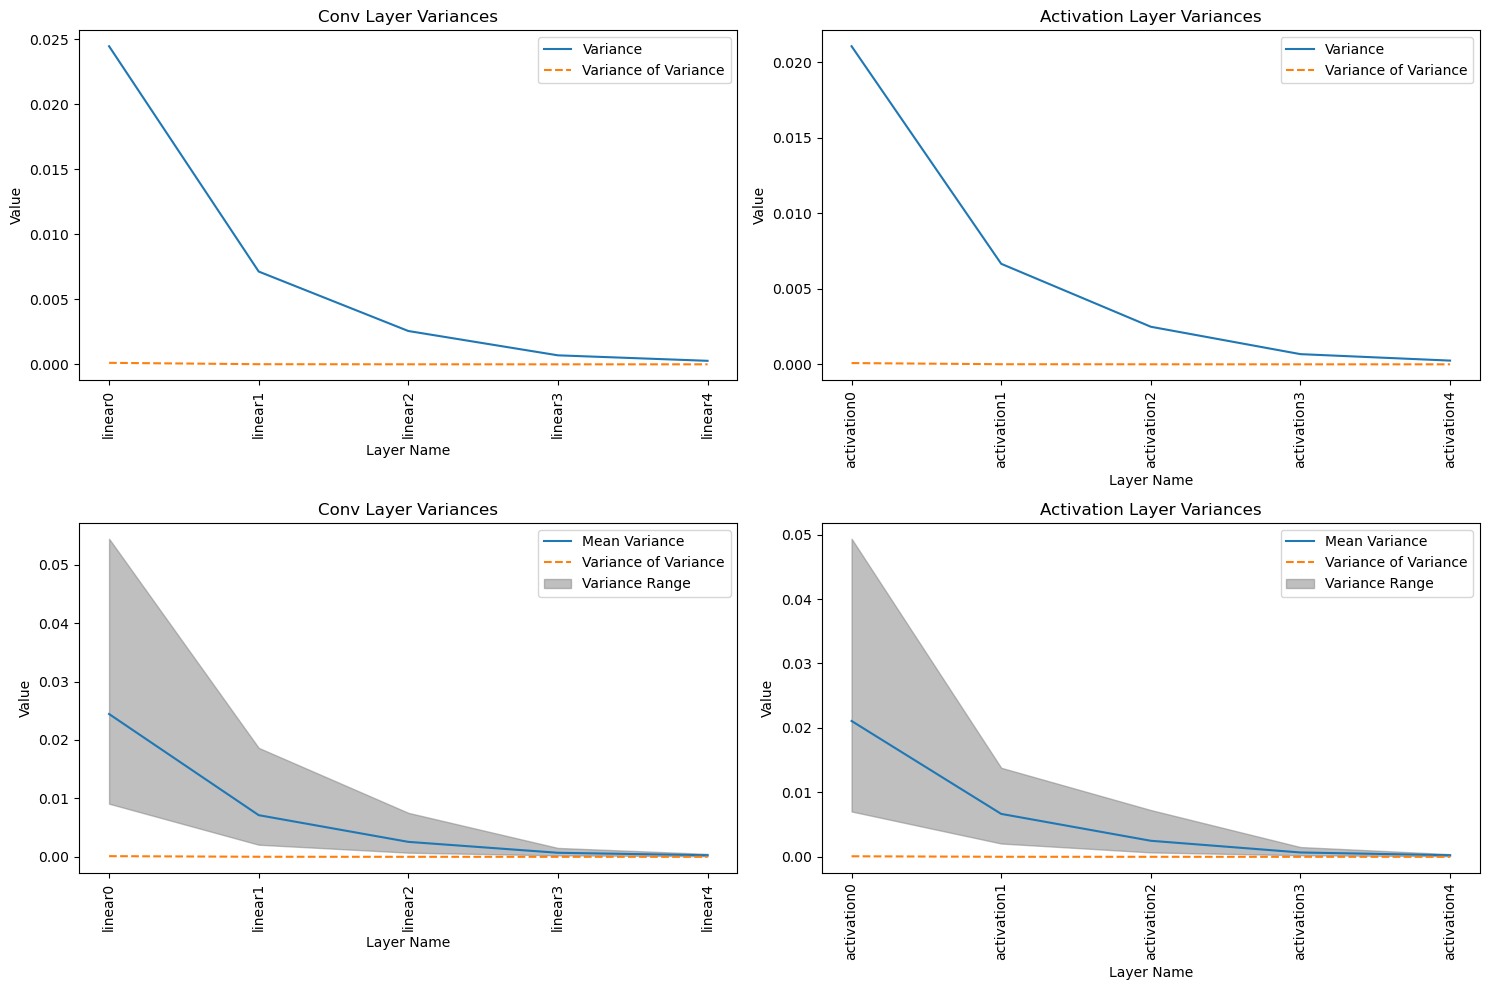

In [47]:
# Create a list of layer names and variances for fc layers
conv_layer_names = [name for name in variances.keys() if 'lin' in name]
conv_variance_values = [variance.mean().item() for name, variance in variances.items() if 'lin' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'act' in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'act' in name]

# Extract variance of variance values
conv_variance_of_variance_values = [results[name]['variance_of_variance'] for name in conv_layer_names]
activation_variance_of_variance_values = [results[name]['variance_of_variance'] for name in activation_layer_names]
pool_variance_of_variance_values = [results[name]['variance_of_variance'] for name in pool_layer_names]

# Create lists for mean, min, and max variance for each type of layer
def extract_variances_from_names(names, variances):
    mean_vals = [variances[name].mean().item() for name in names]
    min_vals = [variances[name].min().item() for name in names]
    max_vals = [variances[name].max().item() for name in names]
    return mean_vals, min_vals, max_vals

conv_mean, conv_min, conv_max = extract_variances_from_names(conv_layer_names, variances)
activation_mean, activation_min, activation_max = extract_variances_from_names(activation_layer_names, variances)
pool_mean, pool_min, pool_max = extract_variances_from_names(pool_layer_names, variances)

def extract_variance_of_variance_from_names(names, results):
    return [results[name]['variance_of_variance'] for name in names]

conv_vov = extract_variance_of_variance_from_names(conv_layer_names, results)
activation_vov = extract_variance_of_variance_from_names(activation_layer_names, results)
pool_vov = extract_variance_of_variance_from_names(pool_layer_names, results)

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the variances and variance of variances for conv layers
axs[0, 0].plot(conv_layer_names, conv_variance_values, label='Variance')
axs[0, 0].plot(conv_layer_names, conv_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[0, 0].set_xticklabels(conv_layer_names, rotation=90)
axs[0, 0].set_xlabel('Layer Name')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Conv Layer Variances')
axs[0, 0].legend()

# Plot the variances and variance of variances for activation layers
axs[0, 1].plot(activation_layer_names, activation_variance_values, label='Variance')
axs[0, 1].plot(activation_layer_names, activation_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[0, 1].set_xticklabels(activation_layer_names, rotation=90)
axs[0, 1].set_xlabel('Layer Name')
axs[0, 1].set_ylabel('Value')
axs[0, 1].set_title('Activation Layer Variances')
axs[0, 1].legend()

# Plot the variances for conv layers
axs[1, 0].plot(conv_layer_names, conv_mean, label='Mean Variance')
axs[1, 0].plot(conv_layer_names, conv_vov, linestyle='--', label='Variance of Variance')
axs[1, 0].fill_between(conv_layer_names, conv_min, conv_max, color='gray', alpha=0.5, label='Variance Range')
axs[1, 0].set_xticklabels(conv_layer_names, rotation=90)
axs[1, 0].set_xlabel('Layer Name')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_title('Conv Layer Variances')
axs[1, 0].legend()

# Plot the variances for activation layers
axs[1, 1].plot(activation_layer_names, activation_mean, label='Mean Variance')
axs[1, 1].plot(activation_layer_names, activation_vov, linestyle='--', label='Variance of Variance')
axs[1, 1].fill_between(activation_layer_names, activation_min, activation_max, color='gray', alpha=0.5, label='Variance Range')
axs[1, 1].set_xticklabels(activation_layer_names, rotation=90)
axs[1, 1].set_xlabel('Layer Name')
axs[1, 1].set_ylabel('Value')
axs[1, 1].set_title('Activation Layer Variances')
axs[1, 1].legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [48]:
pretrain_train_acc, pretrain_test_acc, pre_trained_model, pretraining_checkpoints = compute_training_acc_epochs(model, dataset_wrapped, params, debug=True)

Epoch: 0 	Training Accuracy: 31.98%
Validation Accuracy: 32.82%
Epoch: 1 	Training Accuracy: 54.56%
Validation Accuracy: 55.44%
Epoch: 2 	Training Accuracy: 77.74%
Validation Accuracy: 76.89%
Epoch: 3 	Training Accuracy: 89.38%
Validation Accuracy: 88.95%


In [49]:
# Save model state dictionary
torch.save(pre_trained_model.state_dict(), "pretrained_MNIST_model_50-50.pth")
torch.save(pretraining_checkpoints, 'pretrained_MNIST_model_50-50_checkpoints.pth')

Layer linear0 - Variance: 0.24218156933784485, Variance of Variance: 0.03702915832400322
Layer activation0 - Variance: 0.1530611217021942, Variance of Variance: 0.010686174966394901
Layer linear1 - Variance: 0.21669939160346985, Variance of Variance: 0.046892158687114716
Layer activation1 - Variance: 0.14586977660655975, Variance of Variance: 0.011890952475368977
Layer linear2 - Variance: 0.2245662808418274, Variance of Variance: 0.040540941059589386
Layer activation2 - Variance: 0.15065059065818787, Variance of Variance: 0.014026271179318428
Layer linear3 - Variance: 0.29651105403900146, Variance of Variance: 0.09401200711727142
Layer activation3 - Variance: 0.17975100874900818, Variance of Variance: 0.023595182225108147
Layer linear4 - Variance: 1.8580554723739624, Variance of Variance: 6.908026218414307
Layer activation4 - Variance: 1.9610481262207031, Variance of Variance: 7.04905366897583


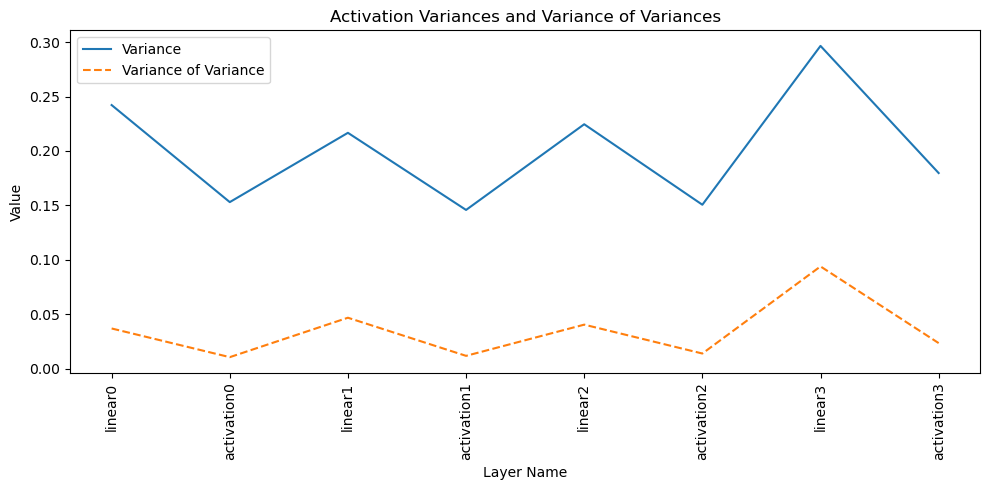

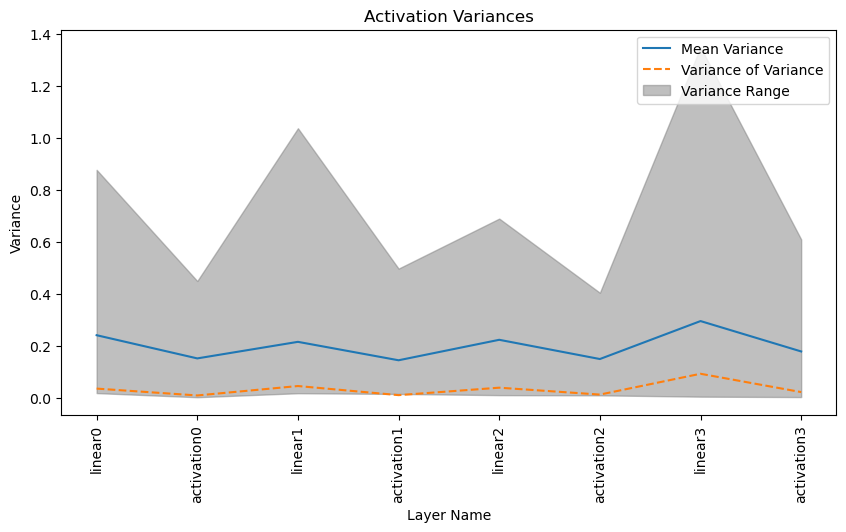

In [50]:
results, variances = compute_layer_variances_dense(pre_trained_model, dataset_wrapped.train_loader, device = 'cpu')
for layer_name, stats in results.items():
    print(f"Layer {layer_name} - Variance: {stats['variance']}, Variance of Variance: {stats['variance_of_variance']}")


import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]
variance_of_variance_values = [results[layer]['variance_of_variance'] for layer in layer_names]

# Plot the variances
plt.figure(figsize=(10, 5))
plt.plot(layer_names[:-2], variance_values[:-2], label='Variance')
plt.plot(layer_names[:-2], variance_of_variance_values[:-2], label='Variance of Variance', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Value')
plt.title('Activation Variances and Variance of Variances')
plt.legend()
plt.tight_layout()
plt.show()

# Create lists for mean, min, and max variance for each layer
layer_names = list(variances.keys())
mean_variances = [variance.mean().item() for variance in variances.values()]
min_variances = [variance.min().item() for variance in variances.values()]
max_variances = [variance.max().item() for variance in variances.values()]

# Plot the variances
plt.figure(figsize=(10, 5))
plt.plot(layer_names[:-2], mean_variances[:-2], label='Mean Variance')
plt.plot(layer_names[:-2], variance_of_variance_values[:-2], label='Variance of Variance', linestyle='--')

# Shade the region between the min and max variance
plt.fill_between(layer_names[:-2], min_variances[:-2], max_variances[:-2], color='gray', alpha=0.5, label='Variance Range')

plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.legend()
plt.show()

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/518272651.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(conv_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/518272651.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(activation_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/518272651.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(conv_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/518272651.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(activation_layer_names, rotation=90)


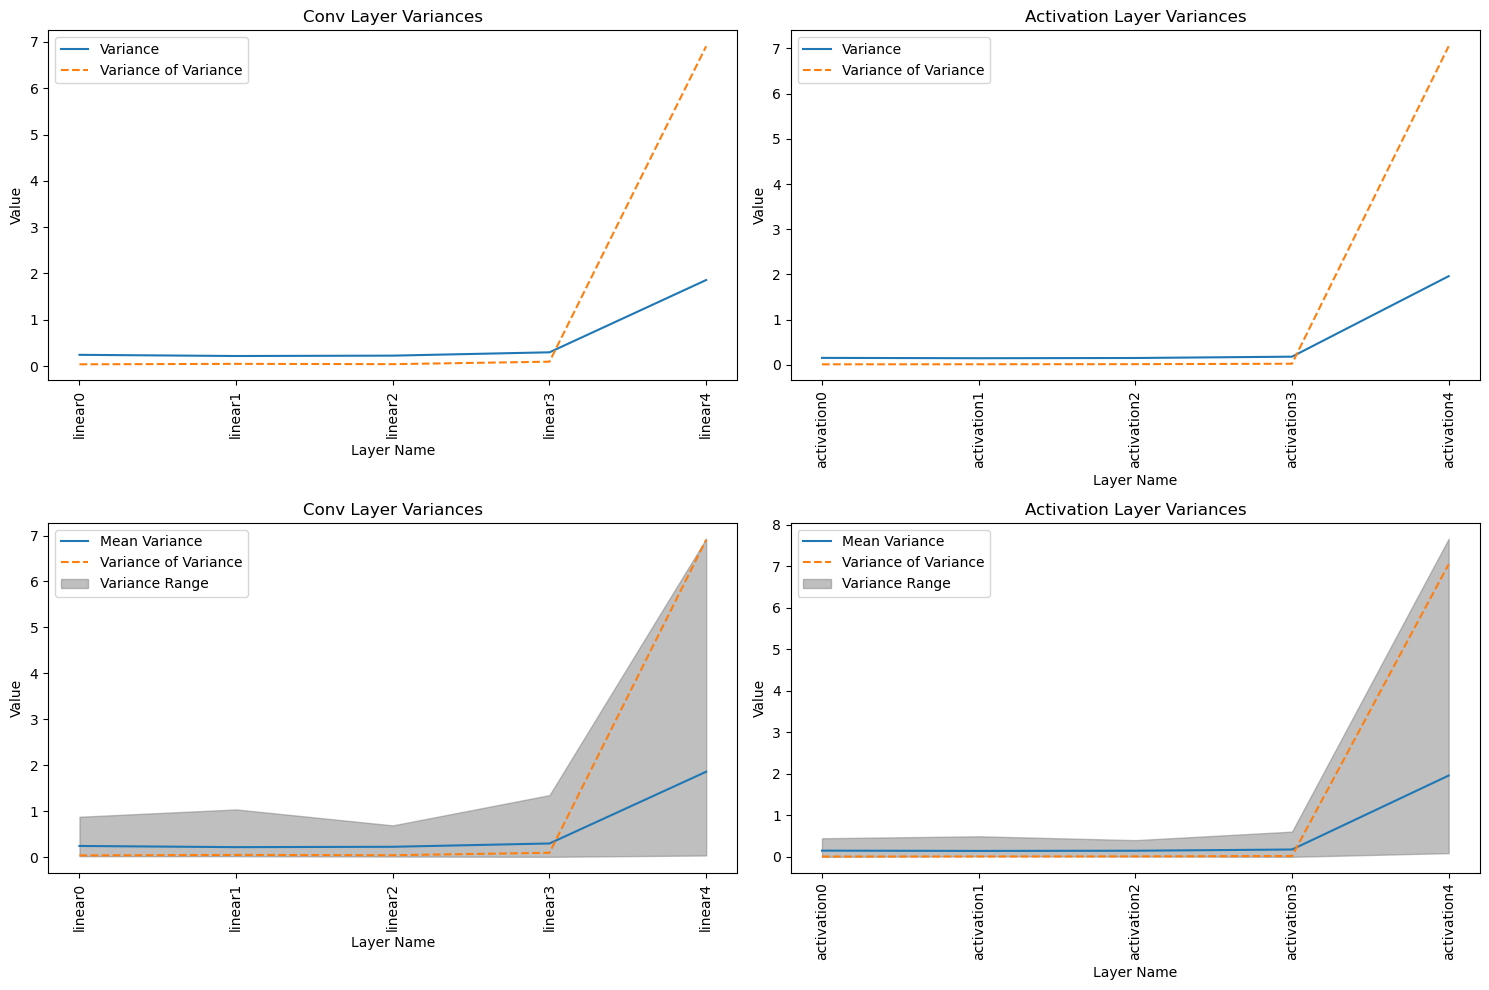

In [51]:
# Create a list of layer names and variances for fc layers
conv_layer_names = [name for name in variances.keys() if 'lin' in name]
conv_variance_values = [variance.mean().item() for name, variance in variances.items() if 'lin' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'act' in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'act' in name]

# Extract variance of variance values
conv_variance_of_variance_values = [results[name]['variance_of_variance'] for name in conv_layer_names]
activation_variance_of_variance_values = [results[name]['variance_of_variance'] for name in activation_layer_names]
pool_variance_of_variance_values = [results[name]['variance_of_variance'] for name in pool_layer_names]

# Create lists for mean, min, and max variance for each type of layer
def extract_variances_from_names(names, variances):
    mean_vals = [variances[name].mean().item() for name in names]
    min_vals = [variances[name].min().item() for name in names]
    max_vals = [variances[name].max().item() for name in names]
    return mean_vals, min_vals, max_vals

conv_mean, conv_min, conv_max = extract_variances_from_names(conv_layer_names, variances)
activation_mean, activation_min, activation_max = extract_variances_from_names(activation_layer_names, variances)
pool_mean, pool_min, pool_max = extract_variances_from_names(pool_layer_names, variances)

def extract_variance_of_variance_from_names(names, results):
    return [results[name]['variance_of_variance'] for name in names]

conv_vov = extract_variance_of_variance_from_names(conv_layer_names, results)
activation_vov = extract_variance_of_variance_from_names(activation_layer_names, results)
pool_vov = extract_variance_of_variance_from_names(pool_layer_names, results)

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the variances and variance of variances for conv layers
axs[0, 0].plot(conv_layer_names, conv_variance_values, label='Variance')
axs[0, 0].plot(conv_layer_names, conv_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[0, 0].set_xticklabels(conv_layer_names, rotation=90)
axs[0, 0].set_xlabel('Layer Name')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Conv Layer Variances')
axs[0, 0].legend()

# Plot the variances and variance of variances for activation layers
axs[0, 1].plot(activation_layer_names, activation_variance_values, label='Variance')
axs[0, 1].plot(activation_layer_names, activation_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[0, 1].set_xticklabels(activation_layer_names, rotation=90)
axs[0, 1].set_xlabel('Layer Name')
axs[0, 1].set_ylabel('Value')
axs[0, 1].set_title('Activation Layer Variances')
axs[0, 1].legend()

# Plot the variances for conv layers
axs[1, 0].plot(conv_layer_names, conv_mean, label='Mean Variance')
axs[1, 0].plot(conv_layer_names, conv_vov, linestyle='--', label='Variance of Variance')
axs[1, 0].fill_between(conv_layer_names, conv_min, conv_max, color='gray', alpha=0.5, label='Variance Range')
axs[1, 0].set_xticklabels(conv_layer_names, rotation=90)
axs[1, 0].set_xlabel('Layer Name')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_title('Conv Layer Variances')
axs[1, 0].legend()

# Plot the variances for activation layers
axs[1, 1].plot(activation_layer_names, activation_mean, label='Mean Variance')
axs[1, 1].plot(activation_layer_names, activation_vov, linestyle='--', label='Variance of Variance')
axs[1, 1].fill_between(activation_layer_names, activation_min, activation_max, color='gray', alpha=0.5, label='Variance Range')
axs[1, 1].set_xticklabels(activation_layer_names, rotation=90)
axs[1, 1].set_xlabel('Layer Name')
axs[1, 1].set_ylabel('Value')
axs[1, 1].set_title('Activation Layer Variances')
axs[1, 1].legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/3377915565.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx + 1, 0].set_xticklabels(conv_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/3377915565.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx + 1, 1].set_xticklabels(activation_layer_names, rotation=90)


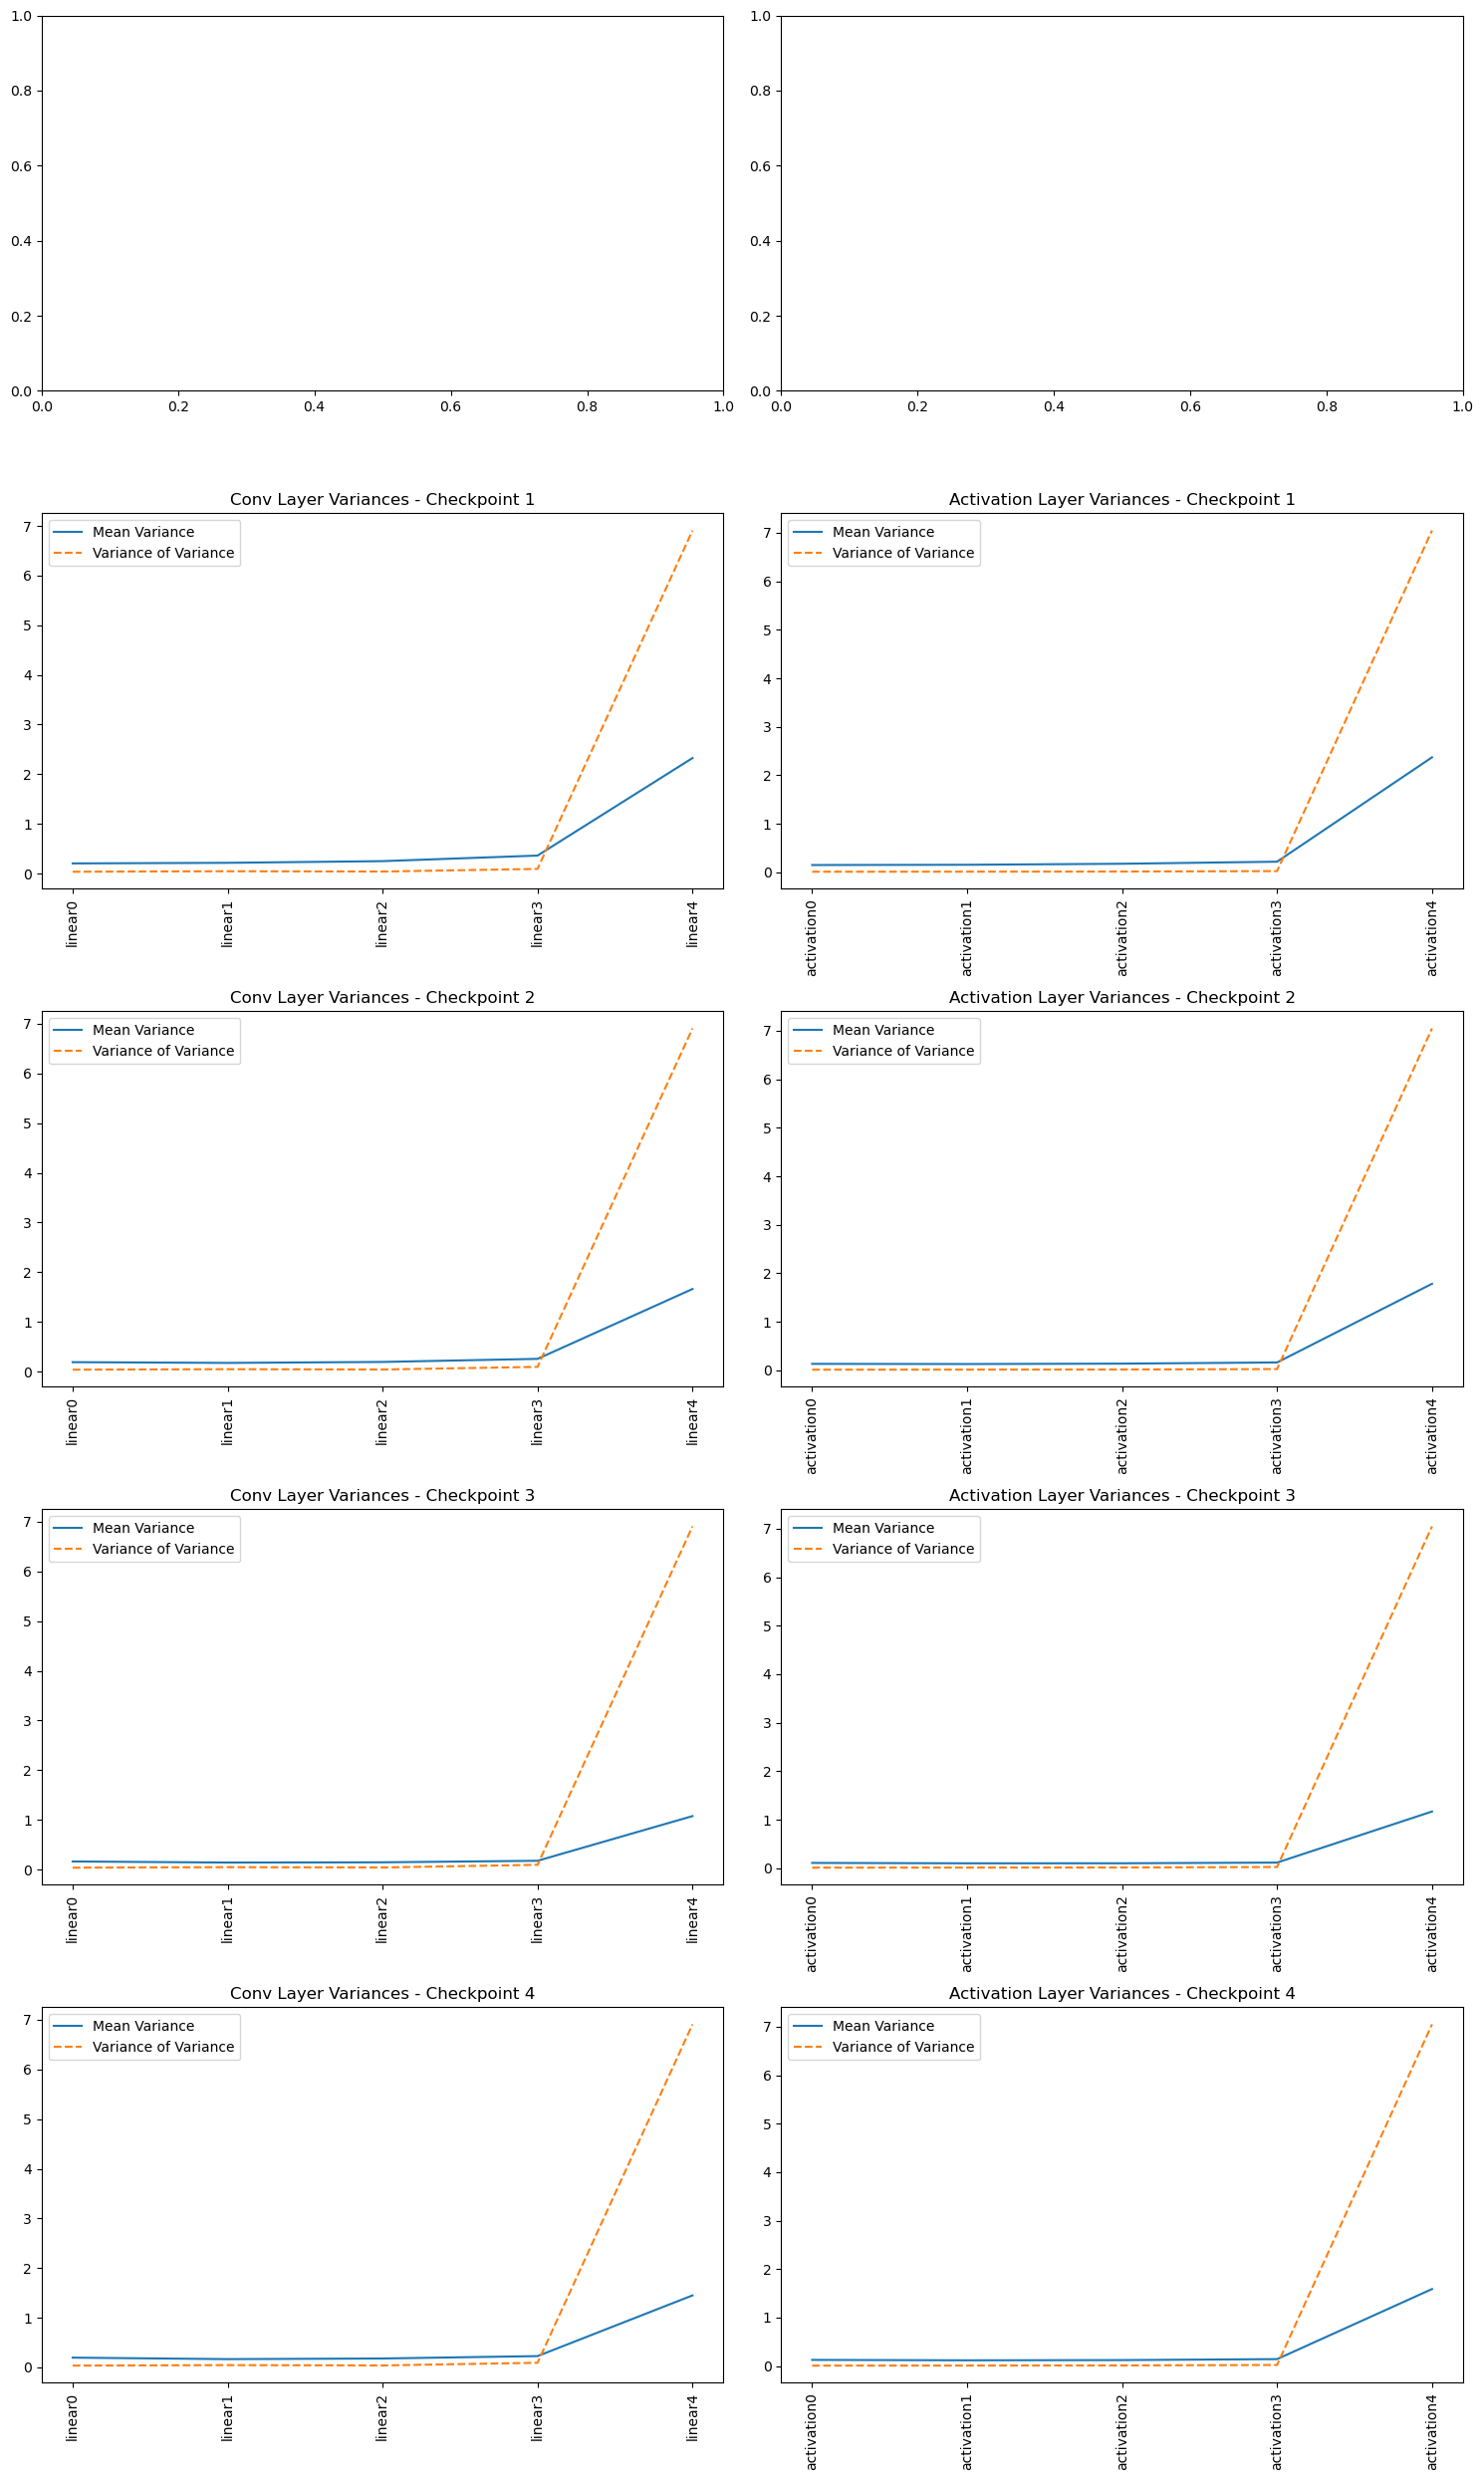

In [60]:
# Assuming your model and dataset variables are already defined
num_pretraining_checkpoints = len(pretraining_checkpoints)

# Create a function to extract variance of variances:
def extract_variance_of_variance_from_names(names, results):
    return [results[name]['variance_of_variance'] for name in names]

# Create a figure with an additional row for each checkpoint
fig, axs = plt.subplots(num_pretraining_checkpoints + 1, 2, figsize=(15, 5 * (num_pretraining_checkpoints + 1)))

# Your original plotting code (for the baseline model) goes here...

model = generate_fc_dnn(dataset.input_dim, dataset.output_dim,
                params).to(device)

# Now, loop through the pretraining_checkpoints
for idx, checkpoint in enumerate(pretraining_checkpoints):
    # Load model state_dict from checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Compute the layer variances for the checkpointed model
    _, variances_checkpoint = compute_layer_variances_dense(model, dataset_wrapped.train_loader, device='cpu')

    # Extract variances and variance of variances for each type of layer
    conv_mean, conv_min, conv_max = extract_variances_from_names(conv_layer_names, variances_checkpoint)
    conv_vov = extract_variance_of_variance_from_names(conv_layer_names, results)
    activation_mean, activation_min, activation_max = extract_variances_from_names(activation_layer_names, variances_checkpoint)
    activation_vov = extract_variance_of_variance_from_names(activation_layer_names, results)
    pool_mean, pool_min, pool_max = extract_variances_from_names(pool_layer_names, variances_checkpoint)
    pool_vov = extract_variance_of_variance_from_names(pool_layer_names, results)
    
    # Plot variances for conv layers
    axs[idx + 1, 0].plot(conv_layer_names, conv_mean, label='Mean Variance')
    axs[idx + 1, 0].plot(conv_layer_names, conv_vov, linestyle='--', label='Variance of Variance')
    #axs[idx + 1, 0].fill_between(conv_layer_names, conv_min, conv_max, color='gray', alpha=0.5, label='Variance Range')
    axs[idx + 1, 0].set_xticklabels(conv_layer_names, rotation=90)
    axs[idx + 1, 0].set_title(f'Conv Layer Variances - Checkpoint {idx + 1}')
    axs[idx + 1, 0].legend()

    # Plot variances for activation layers
    axs[idx + 1, 1].plot(activation_layer_names, activation_mean, label='Mean Variance')
    axs[idx + 1, 1].plot(activation_layer_names, activation_vov, linestyle='--', label='Variance of Variance')
    #axs[idx + 1, 1].fill_between(activation_layer_names, activation_min, activation_max, color='gray', alpha=0.5, label='Variance Range')
    axs[idx + 1, 1].set_xticklabels(activation_layer_names, rotation=90)
    axs[idx + 1, 1].set_title(f'Activation Layer Variances - Checkpoint {idx + 1}')
    axs[idx + 1, 1].legend()

    '''# Plot variances for pool layers
    axs[idx + 1, 2].plot(pool_layer_names, pool_mean, label='Mean Variance')
    axs[idx + 1, 2].plot(pool_layer_names, pool_vov, linestyle='--', label='Variance of Variance')
    axs[idx + 1, 2].fill_between(pool_layer_names, pool_min, pool_max, color='gray', alpha=0.5, label='Variance Range')
    axs[idx + 1, 2].set_xticklabels(pool_layer_names, rotation=90)
    axs[idx + 1, 2].set_title(f'Pool Layer Variances - Checkpoint {idx + 1}')
    axs[idx + 1, 2].legend()'''

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [61]:
test_acc = eval(pre_trained_model, device, dataset.pretrain_test_loader, False)
print(f"Test Accuracy on training classes: {test_acc:.2f}%")

test_acc_transfer = eval(pre_trained_model, device, dataset.finetune_test_loader, False)
print(f"Test Accuracy on finetuning classes: {test_acc_transfer:.2f}%")

Test Accuracy on training classes: 0.90%
Test Accuracy on finetuning classes: 0.00%


#### finetuning expermient

In [62]:
dataset_wrapped.update_phase('finetune')

In [63]:
results, variances = compute_layer_variances_dense(pre_trained_model, dataset_wrapped.train_loader, device = 'cpu')
for layer_name, stats in results.items():
    print(f"Layer {layer_name} - Variance: {stats['variance']}, Variance of Variance: {stats['variance_of_variance']}")

Layer linear0 - Variance: 0.0771200954914093, Variance of Variance: 0.002487940713763237
Layer activation0 - Variance: 0.059228211641311646, Variance of Variance: 0.0013561550294980407
Layer linear1 - Variance: 0.07195832580327988, Variance of Variance: 0.003157295286655426
Layer activation1 - Variance: 0.05777326598763466, Variance of Variance: 0.0016739388229325414
Layer linear2 - Variance: 0.08469631522893906, Variance of Variance: 0.004901146050542593
Layer activation2 - Variance: 0.06472405791282654, Variance of Variance: 0.0025578332133591175
Layer linear3 - Variance: 0.11965394765138626, Variance of Variance: 0.011727857403457165
Layer activation3 - Variance: 0.08271636813879013, Variance of Variance: 0.005075110588222742
Layer linear4 - Variance: 0.8248995542526245, Variance of Variance: 1.1714147329330444
Layer activation4 - Variance: 0.893438994884491, Variance of Variance: 1.200479507446289


/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/1676317055.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(conv_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/1676317055.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(activation_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/1676317055.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(conv_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_10733/1676317055.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(activation_layer_names, rotation=90)


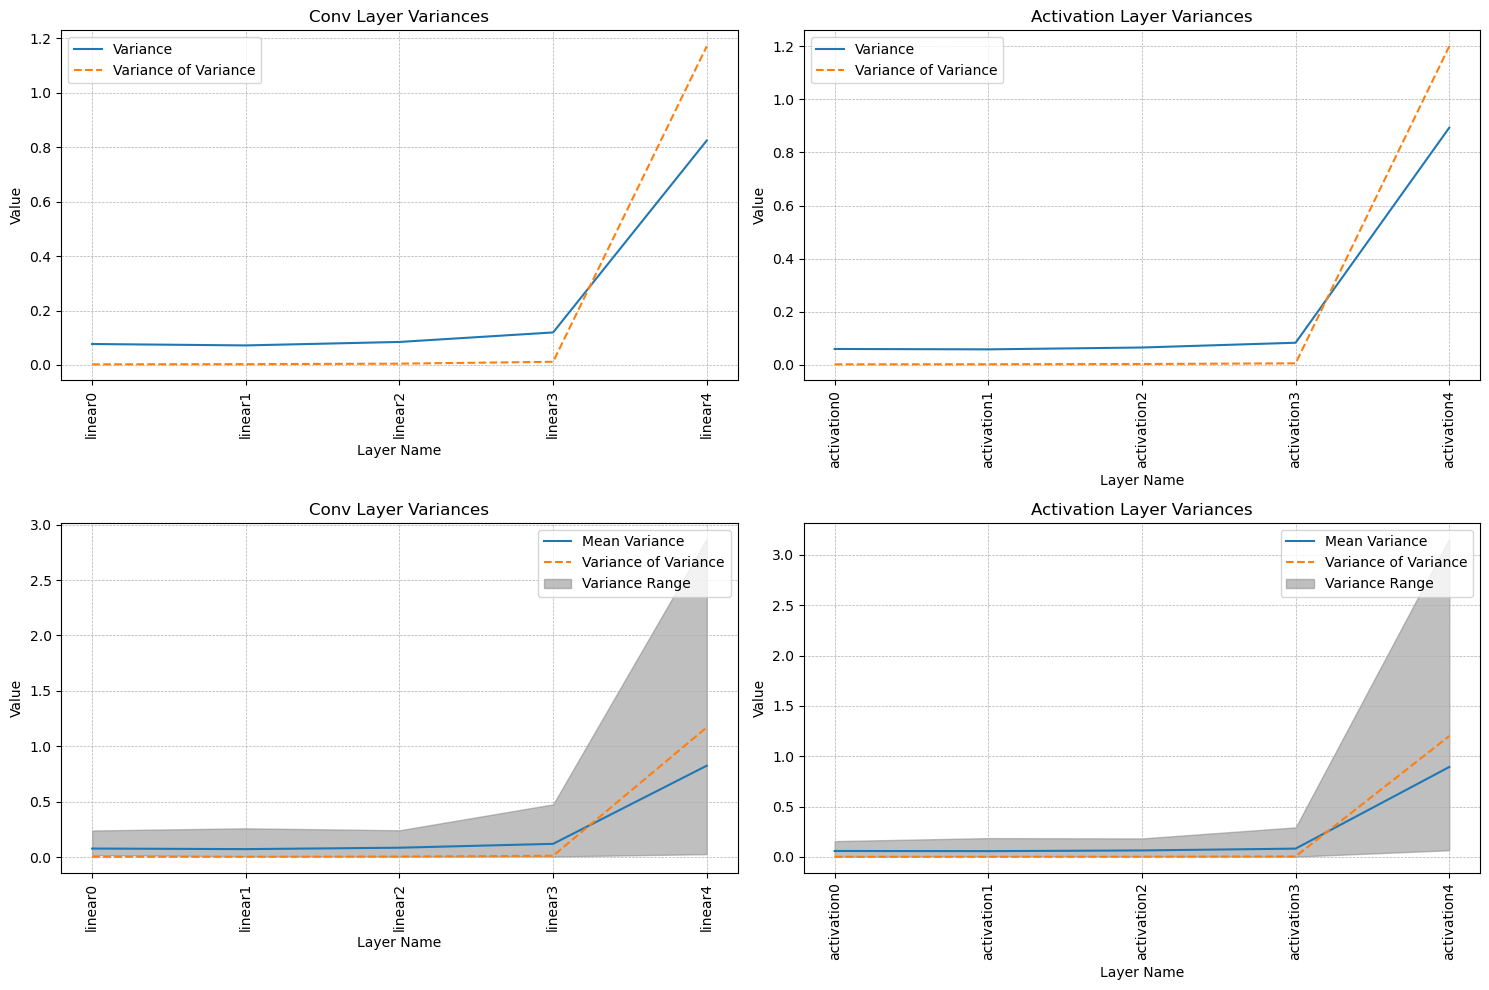

In [65]:
# Create a list of layer names and variances for fc layers
conv_layer_names = [name for name in variances.keys() if 'lin' in name]
conv_variance_values = [variance.mean().item() for name, variance in variances.items() if 'lin' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'act' in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'act' in name]

# Extract variance of variance values
conv_variance_of_variance_values = [results[name]['variance_of_variance'] for name in conv_layer_names]
activation_variance_of_variance_values = [results[name]['variance_of_variance'] for name in activation_layer_names]
pool_variance_of_variance_values = [results[name]['variance_of_variance'] for name in pool_layer_names]

# Create lists for mean, min, and max variance for each type of layer
def extract_variances_from_names(names, variances):
    mean_vals = [variances[name].mean().item() for name in names]
    min_vals = [variances[name].min().item() for name in names]
    max_vals = [variances[name].max().item() for name in names]
    return mean_vals, min_vals, max_vals

conv_mean, conv_min, conv_max = extract_variances_from_names(conv_layer_names, variances)
activation_mean, activation_min, activation_max = extract_variances_from_names(activation_layer_names, variances)
pool_mean, pool_min, pool_max = extract_variances_from_names(pool_layer_names, variances)

def extract_variance_of_variance_from_names(names, results):
    return [results[name]['variance_of_variance'] for name in names]

conv_vov = extract_variance_of_variance_from_names(conv_layer_names, results)
activation_vov = extract_variance_of_variance_from_names(activation_layer_names, results)
pool_vov = extract_variance_of_variance_from_names(pool_layer_names, results)

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the variances and variance of variances for conv layers
axs[0, 0].plot(conv_layer_names, conv_variance_values, label='Variance')
axs[0, 0].plot(conv_layer_names, conv_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[0, 0].set_xticklabels(conv_layer_names, rotation=90)
axs[0, 0].set_xlabel('Layer Name')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Conv Layer Variances')
axs[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0, 0].legend()

# Plot the variances and variance of variances for activation layers
axs[0, 1].plot(activation_layer_names, activation_variance_values, label='Variance')
axs[0, 1].plot(activation_layer_names, activation_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[0, 1].set_xticklabels(activation_layer_names, rotation=90)
axs[0, 1].set_xlabel('Layer Name')
axs[0, 1].set_ylabel('Value')
axs[0, 1].set_title('Activation Layer Variances')
axs[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0, 1].legend()

# Plot the variances for conv layers
axs[1, 0].plot(conv_layer_names, conv_mean, label='Mean Variance')
axs[1, 0].plot(conv_layer_names, conv_vov, linestyle='--', label='Variance of Variance')
axs[1, 0].fill_between(conv_layer_names, conv_min, conv_max, color='gray', alpha=0.5, label='Variance Range')
axs[1, 0].set_xticklabels(conv_layer_names, rotation=90)
axs[1, 0].set_xlabel('Layer Name')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_title('Conv Layer Variances')
axs[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1, 0].legend()

# Plot the variances for activation layers
axs[1, 1].plot(activation_layer_names, activation_mean, label='Mean Variance')
axs[1, 1].plot(activation_layer_names, activation_vov, linestyle='--', label='Variance of Variance')
axs[1, 1].fill_between(activation_layer_names, activation_min, activation_max, color='gray', alpha=0.5, label='Variance Range')
axs[1, 1].set_xticklabels(activation_layer_names, rotation=90)
axs[1, 1].set_xlabel('Layer Name')
axs[1, 1].set_ylabel('Value')
axs[1, 1].set_title('Activation Layer Variances')
axs[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1, 1].legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [71]:
from tqdm import tqdm

num_experiments = 5
experiments = []

for i in tqdm(range(num_experiments)):
    print('experiment number: ', i)
    cut_models = []
    for cut in range(depth):
        temp = {}
        temp['cut_model'] = cut_model(pre_trained_model, cut_point = cut, freeze = True)
        finetuned_acc, finetuned_test_acc, finetuned_model ,checkpoints_temp = compute_training_acc_epochs(temp['cut_model'], dataset_wrapped, params, debug=True)
        temp['finetuned_acc'] = finetuned_acc
        temp['finetuned_test_acc'] = finetuned_test_acc
        temp['finetuned_model'] = finetuned_model
        temp['checkpoints'] = checkpoints_temp
        cut_models.append(temp)  
    experiments.append(cut_models)

experiment number:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 	Training Accuracy: 74.48%
Validation Accuracy: 73.47%
Epoch: 1 	Training Accuracy: 84.92%
Validation Accuracy: 85.71%
Epoch: 2 	Training Accuracy: 88.43%
Validation Accuracy: 88.88%
Epoch: 3 	Training Accuracy: 90.11%
Validation Accuracy: 90.44%


 20%|██        | 1/5 [00:11<00:45, 11.36s/it]

Epoch: 0 	Training Accuracy: 59.24%
Validation Accuracy: 59.46%
Epoch: 1 	Training Accuracy: 66.19%
Validation Accuracy: 64.83%
Epoch: 2 	Training Accuracy: 69.79%
Validation Accuracy: 68.81%
Epoch: 3 	Training Accuracy: 73.63%
Validation Accuracy: 73.23%


 40%|████      | 2/5 [00:22<00:33, 11.26s/it]

Epoch: 0 	Training Accuracy: 57.13%
Validation Accuracy: 56.73%
Epoch: 1 	Training Accuracy: 61.52%
Validation Accuracy: 60.85%
Epoch: 2 	Training Accuracy: 62.96%
Validation Accuracy: 62.93%
Epoch: 3 	Training Accuracy: 63.31%
Validation Accuracy: 63.13%


 60%|██████    | 3/5 [00:33<00:22, 11.34s/it]

Epoch: 0 	Training Accuracy: 54.32%
Validation Accuracy: 53.98%
Epoch: 1 	Training Accuracy: 58.29%
Validation Accuracy: 56.90%
Epoch: 2 	Training Accuracy: 61.54%
Validation Accuracy: 60.68%
Epoch: 3 	Training Accuracy: 61.43%
Validation Accuracy: 60.54%
val_acc: 0.6054421768707483, max_val_acc: 0.6068027210884354, no_improve_epochs: 1


 80%|████████  | 4/5 [00:45<00:11, 11.34s/it]

Epoch: 0 	Training Accuracy: 37.42%
Validation Accuracy: 37.35%
Epoch: 1 	Training Accuracy: 39.08%
Validation Accuracy: 40.00%
Epoch: 2 	Training Accuracy: 43.37%
Validation Accuracy: 44.15%
Epoch: 3 	Training Accuracy: 45.61%
Validation Accuracy: 45.58%


100%|██████████| 5/5 [00:56<00:00, 11.35s/it]


experiment number:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 	Training Accuracy: 68.33%
Validation Accuracy: 68.78%
Epoch: 1 	Training Accuracy: 81.71%
Validation Accuracy: 83.44%
Epoch: 2 	Training Accuracy: 86.72%
Validation Accuracy: 88.13%
Epoch: 3 	Training Accuracy: 89.38%
Validation Accuracy: 90.27%


 20%|██        | 1/5 [00:11<00:46, 11.69s/it]

Epoch: 0 	Training Accuracy: 55.66%
Validation Accuracy: 56.19%
Epoch: 1 	Training Accuracy: 65.55%
Validation Accuracy: 63.84%
Epoch: 2 	Training Accuracy: 67.85%
Validation Accuracy: 66.94%
Epoch: 3 	Training Accuracy: 71.54%
Validation Accuracy: 70.44%


 40%|████      | 2/5 [00:23<00:34, 11.49s/it]

Epoch: 0 	Training Accuracy: 57.06%
Validation Accuracy: 56.36%
Epoch: 1 	Training Accuracy: 60.04%
Validation Accuracy: 58.95%
Epoch: 2 	Training Accuracy: 62.10%
Validation Accuracy: 61.53%
Epoch: 3 	Training Accuracy: 63.71%
Validation Accuracy: 62.99%


 60%|██████    | 3/5 [00:34<00:22, 11.33s/it]

Epoch: 0 	Training Accuracy: 53.71%
Validation Accuracy: 53.98%
Epoch: 1 	Training Accuracy: 57.60%
Validation Accuracy: 56.60%
Epoch: 2 	Training Accuracy: 59.07%
Validation Accuracy: 58.47%
Epoch: 3 	Training Accuracy: 61.45%
Validation Accuracy: 60.20%


 80%|████████  | 4/5 [00:45<00:11, 11.24s/it]

Epoch: 0 	Training Accuracy: 34.08%
Validation Accuracy: 33.40%
Epoch: 1 	Training Accuracy: 43.49%
Validation Accuracy: 43.98%
Epoch: 2 	Training Accuracy: 45.02%
Validation Accuracy: 45.71%
Epoch: 3 	Training Accuracy: 46.54%
Validation Accuracy: 46.94%


100%|██████████| 5/5 [00:56<00:00, 11.24s/it]


experiment number:  2


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 	Training Accuracy: 67.87%
Validation Accuracy: 69.66%
Epoch: 1 	Training Accuracy: 80.63%
Validation Accuracy: 81.12%
Epoch: 2 	Training Accuracy: 87.38%
Validation Accuracy: 87.07%
Epoch: 3 	Training Accuracy: 89.79%
Validation Accuracy: 89.76%


 20%|██        | 1/5 [00:11<00:44, 11.16s/it]

Epoch: 0 	Training Accuracy: 56.95%
Validation Accuracy: 55.71%
Epoch: 1 	Training Accuracy: 63.35%
Validation Accuracy: 61.53%
Epoch: 2 	Training Accuracy: 68.21%
Validation Accuracy: 67.69%
Epoch: 3 	Training Accuracy: 71.88%
Validation Accuracy: 71.29%


 40%|████      | 2/5 [00:22<00:33, 11.11s/it]

Epoch: 0 	Training Accuracy: 46.84%
Validation Accuracy: 46.53%
Epoch: 1 	Training Accuracy: 55.25%
Validation Accuracy: 54.76%
Epoch: 2 	Training Accuracy: 58.93%
Validation Accuracy: 57.41%
Epoch: 3 	Training Accuracy: 59.41%
Validation Accuracy: 58.50%


 60%|██████    | 3/5 [00:33<00:22, 11.18s/it]

Epoch: 0 	Training Accuracy: 51.67%
Validation Accuracy: 52.28%
Epoch: 1 	Training Accuracy: 54.17%
Validation Accuracy: 54.86%
Epoch: 2 	Training Accuracy: 56.59%
Validation Accuracy: 56.77%
Epoch: 3 	Training Accuracy: 57.29%
Validation Accuracy: 57.04%


 80%|████████  | 4/5 [00:44<00:11, 11.23s/it]

Epoch: 0 	Training Accuracy: 34.89%
Validation Accuracy: 36.39%
Epoch: 1 	Training Accuracy: 43.19%
Validation Accuracy: 43.98%
Epoch: 2 	Training Accuracy: 46.27%
Validation Accuracy: 48.16%
Epoch: 3 	Training Accuracy: 48.14%
Validation Accuracy: 49.76%


100%|██████████| 5/5 [00:55<00:00, 11.19s/it]


experiment number:  3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 	Training Accuracy: 75.31%
Validation Accuracy: 74.97%
Epoch: 1 	Training Accuracy: 84.99%
Validation Accuracy: 84.97%
Epoch: 2 	Training Accuracy: 88.52%
Validation Accuracy: 88.03%
Epoch: 3 	Training Accuracy: 89.96%
Validation Accuracy: 89.90%


 20%|██        | 1/5 [00:11<00:45, 11.35s/it]

Epoch: 0 	Training Accuracy: 64.37%
Validation Accuracy: 63.50%
Epoch: 1 	Training Accuracy: 69.50%
Validation Accuracy: 67.72%
Epoch: 2 	Training Accuracy: 73.58%
Validation Accuracy: 72.24%
Epoch: 3 	Training Accuracy: 76.75%
Validation Accuracy: 75.78%


 40%|████      | 2/5 [00:22<00:33, 11.29s/it]

Epoch: 0 	Training Accuracy: 56.78%
Validation Accuracy: 58.10%
Epoch: 1 	Training Accuracy: 60.03%
Validation Accuracy: 59.76%
Epoch: 2 	Training Accuracy: 61.40%
Validation Accuracy: 60.65%
Epoch: 3 	Training Accuracy: 62.83%
Validation Accuracy: 61.94%


 60%|██████    | 3/5 [00:33<00:22, 11.24s/it]

Epoch: 0 	Training Accuracy: 50.91%
Validation Accuracy: 53.06%
Epoch: 1 	Training Accuracy: 56.92%
Validation Accuracy: 56.94%
Epoch: 2 	Training Accuracy: 60.45%
Validation Accuracy: 60.10%
Epoch: 3 	Training Accuracy: 60.35%
Validation Accuracy: 59.46%
val_acc: 0.5945578231292517, max_val_acc: 0.6010204081632653, no_improve_epochs: 1


 80%|████████  | 4/5 [00:44<00:11, 11.15s/it]

Epoch: 0 	Training Accuracy: 35.67%
Validation Accuracy: 35.82%
Epoch: 1 	Training Accuracy: 44.32%
Validation Accuracy: 44.69%
Epoch: 2 	Training Accuracy: 47.66%
Validation Accuracy: 47.41%
Epoch: 3 	Training Accuracy: 49.24%
Validation Accuracy: 49.39%


100%|██████████| 5/5 [00:55<00:00, 11.14s/it]


experiment number:  4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 	Training Accuracy: 72.24%
Validation Accuracy: 71.67%
Epoch: 1 	Training Accuracy: 82.49%
Validation Accuracy: 83.06%
Epoch: 2 	Training Accuracy: 87.10%
Validation Accuracy: 87.11%
Epoch: 3 	Training Accuracy: 89.16%
Validation Accuracy: 89.35%


 20%|██        | 1/5 [00:11<00:44, 11.12s/it]

Epoch: 0 	Training Accuracy: 53.95%
Validation Accuracy: 55.58%
Epoch: 1 	Training Accuracy: 64.59%
Validation Accuracy: 64.32%
Epoch: 2 	Training Accuracy: 69.59%
Validation Accuracy: 68.47%
Epoch: 3 	Training Accuracy: 71.97%
Validation Accuracy: 71.22%


 40%|████      | 2/5 [00:22<00:33, 11.05s/it]

Epoch: 0 	Training Accuracy: 55.11%
Validation Accuracy: 55.37%
Epoch: 1 	Training Accuracy: 57.81%
Validation Accuracy: 57.31%
Epoch: 2 	Training Accuracy: 60.04%
Validation Accuracy: 58.67%
Epoch: 3 	Training Accuracy: 60.84%
Validation Accuracy: 59.49%


 60%|██████    | 3/5 [00:33<00:22, 11.02s/it]

Epoch: 0 	Training Accuracy: 52.95%
Validation Accuracy: 52.18%
Epoch: 1 	Training Accuracy: 56.13%
Validation Accuracy: 55.24%
Epoch: 2 	Training Accuracy: 58.68%
Validation Accuracy: 57.45%
Epoch: 3 	Training Accuracy: 60.01%
Validation Accuracy: 58.57%


 80%|████████  | 4/5 [00:44<00:11, 11.02s/it]

Epoch: 0 	Training Accuracy: 46.49%
Validation Accuracy: 47.11%
Epoch: 1 	Training Accuracy: 47.51%
Validation Accuracy: 47.86%
Epoch: 2 	Training Accuracy: 50.03%
Validation Accuracy: 50.61%
Epoch: 3 	Training Accuracy: 51.29%
Validation Accuracy: 52.21%


100%|██████████| 5/5 [00:55<00:00, 11.00s/it]


In [72]:
torch.save(experiments, 'experiments_results_MNIST_50-50.pth')

AttributeError: Can't pickle local object 'compute_layer_variances_dense.<locals>.create_hook.<locals>.hook'

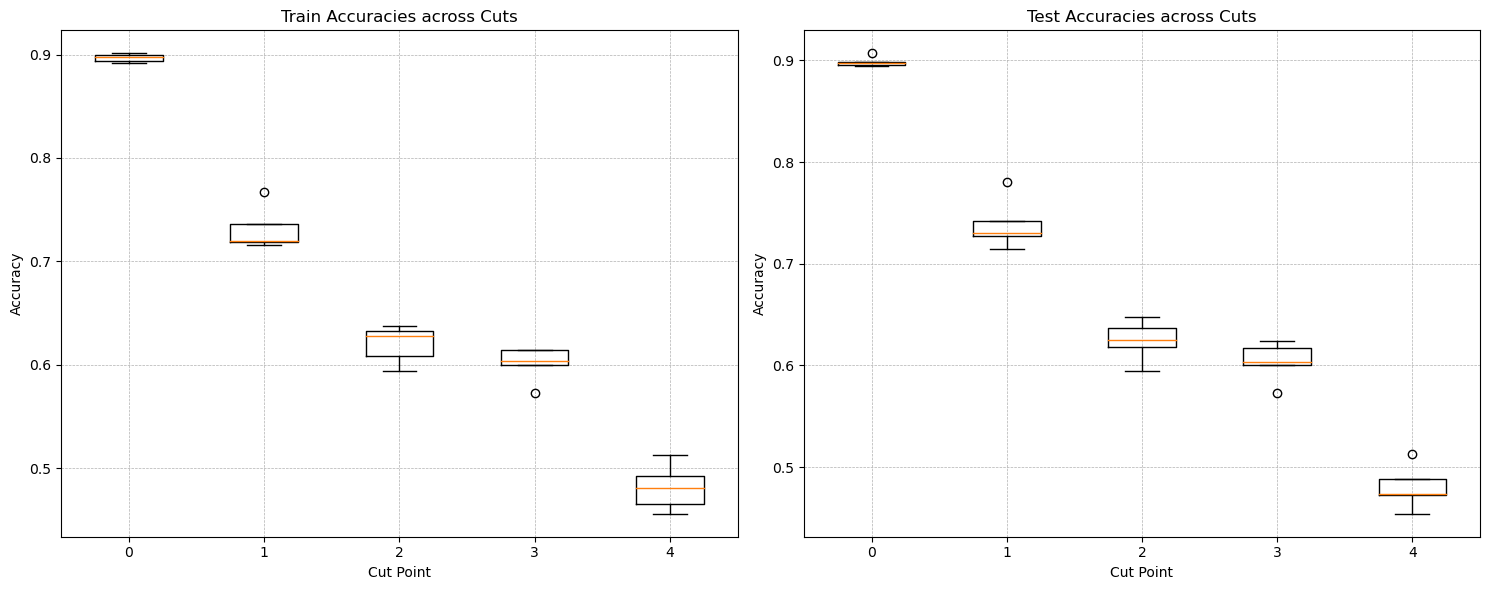

In [73]:
import matplotlib.pyplot as plt

# Initialize lists to store all accuracies for each cut point
train_accuracies = [[] for _ in range(depth)]
test_accuracies = [[] for _ in range(depth)]

# Populate the lists with accuracy values
for cut_models in experiments:
    for cut, model_data in enumerate(cut_models):
        train_accuracies[cut].append(model_data['finetuned_acc'])
        test_accuracies[cut].append(model_data['finetuned_test_acc'])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot training accuracies
axs[0].boxplot(train_accuracies)
axs[0].set_title('Train Accuracies across Cuts')
axs[0].set_xlabel('Cut Point')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(1, depth + 1))
axs[0].set_xticklabels(range(depth))
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot test accuracies
axs[1].boxplot(test_accuracies)
axs[1].set_title('Test Accuracies across Cuts')
axs[1].set_xlabel('Cut Point')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(range(1, depth + 1))
axs[1].set_xticklabels(range(depth))
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

----

In [19]:
cut_models = []

for cut in range(depth):
    temp = {}
    temp['cut_model'] = cut_model(pre_trained_model, sw = 1.5, sb = 1, cut_point = cut)
    finetuned_train_acc, finetuned_test_acc, finetuned_model = compute_training_acc_epochs(temp['cut_model'], dataset_wrapped, params, debug=True)
    temp['finetuned_train_acc'] = finetuned_train_acc
    temp['finetuned_test_acc'] = finetuned_test_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)   

Epoch: 0 	Training Accuracy: 73.21%
Validation Accuracy: 74.49%
Epoch: 1 	Training Accuracy: 83.59%
Validation Accuracy: 83.71%
Epoch: 2 	Training Accuracy: 87.89%
Validation Accuracy: 87.72%
Epoch: 3 	Training Accuracy: 89.93%
Validation Accuracy: 90.00%
Epoch: 0 	Training Accuracy: 57.77%
Validation Accuracy: 58.10%
Epoch: 1 	Training Accuracy: 69.55%
Validation Accuracy: 70.51%
Epoch: 2 	Training Accuracy: 75.39%
Validation Accuracy: 76.80%
Epoch: 3 	Training Accuracy: 79.60%
Validation Accuracy: 80.37%
Epoch: 0 	Training Accuracy: 55.61%
Validation Accuracy: 56.43%
Epoch: 1 	Training Accuracy: 61.05%
Validation Accuracy: 61.56%
Epoch: 2 	Training Accuracy: 64.00%
Validation Accuracy: 65.00%
Epoch: 3 	Training Accuracy: 67.67%
Validation Accuracy: 68.50%
Epoch: 0 	Training Accuracy: 49.88%
Validation Accuracy: 51.22%
Epoch: 1 	Training Accuracy: 55.54%
Validation Accuracy: 57.07%
Epoch: 2 	Training Accuracy: 57.20%
Validation Accuracy: 58.71%
Epoch: 3 	Training Accuracy: 58.77%
Vali

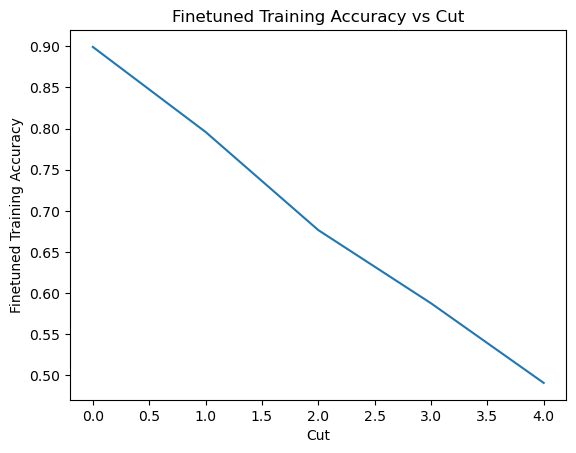

In [20]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_train_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Training Accuracy')
plt.title('Finetuned Training Accuracy vs Cut')
plt.show()

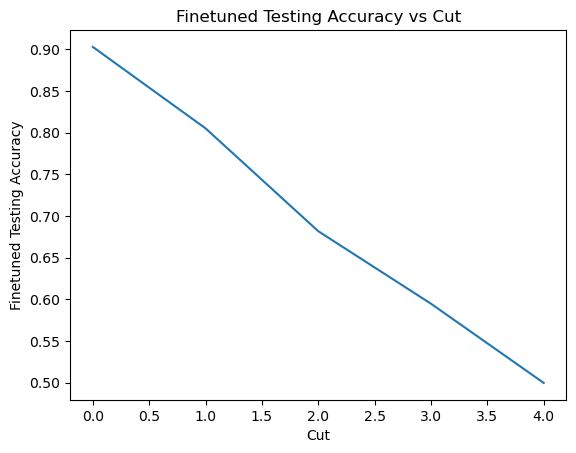

In [21]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_test_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Testing Accuracy')
plt.title('Finetuned Testing Accuracy vs Cut')
plt.show()

-----

## Fashion Mnist

### Baseline, end to end trained model

In [4]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps'
depth = 5

fashion_dataset = FashionMNISTtrainer(batch_size)
params = dict(device=device,
                width=50, lr=0.01, num_train=4,
                sb=1, depth= depth, sw=1.5)

fashion_model = generate_fc_dnn(dataset.input_dim, dataset.output_dim,
                params['depth'], params['width']).to(device)

pretrain_acc, pre_trained_model = compute_training_acc_epochs(fashion_model, fashion_dataset, params, debug=True)

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): Tanh()
  (8): Linear(in_features=50, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Train set: Average loss: 0.8191, Accuracy: 42975.0/60000 (72%)

Epoch: 0 	Training Accuracy: 71.62%

Train set: Average loss: 0.6768, Accuracy: 45237.0/60000 (75%)

Epoch: 1 	Training Accuracy: 75.39%

Train set: Average loss: 0.6093, Accuracy: 46827.0/60000 (78%)

Epoch: 2 	Training Accuracy: 78.05%

Train set: Average loss: 0.5691, Accuracy: 47610.0/60000 (79%)

Epoch: 3 	Training Accuracy: 79.35%

Train set: Average loss: 0.5691, 

### finetuned staring from regular mnist 

In [6]:
#luckily, the number of classes is the same, so we don't need to change the last layer.

cut_models = []

for cut in range(depth):
    temp = {}
    temp['cut_model'] = cut_model(model, sw = 1.5, sb = 1, cut_point = cut)
    finetuned_acc, finetuned_model = compute_training_acc_epochs(temp['cut_model'], fashion_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)   

In [9]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.7911
Cut 1:
0.7381833333333333
Cut 2:
0.6858333333333333
Cut 3:
0.6187833333333334
Cut 4:
0.27591666666666664


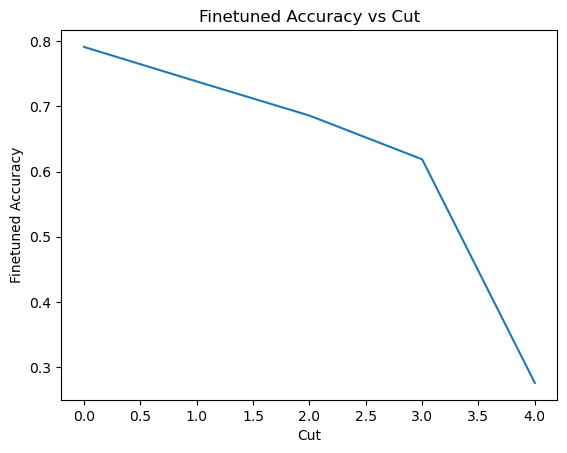

In [7]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

----